# Modifications de résultats des sondages

## Import préliminaires des librairies

In [110]:
#%pylab inline
# Command OS
import os

# Regex
import re

# Calcul and data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import norm
# Dealing with specific representation of number
# Aka commat in french in numbers
import locale
from locale import atof

### Dark theme pour matplotlib ###
from ing_theme_matplotlib import mpl_style
mpl_style(dark=True)

# Perso
from importlib.machinery import SourceFileLoader
tools = SourceFileLoader('methods', '../methods.py').load_module()
from methods import *


## Import du dataframe

In [111]:



filenames=[f.rstrip('.p') for f in os.listdir('data')]
sum_in_margin=0
total_lines=0
df=pd.read_pickle("data/2020-03-20.p")
data_f=pd.DataFrame(columns=df.columns)
for fn in filenames:
    df=pd.read_pickle("data/{}.p".format(fn))
    df.Base=df.Base.astype('float')
    df['Date']=fn
    data_f=pd.concat([data_f,df])
    in_margin,nb_lines=extract_in_margin(df['ST Favorable'],df['ST Défavorable'],df['Evolution ST Favorable'],df['Evolution ST Défavorable'],df.Base)
    sum_in_margin+=in_margin
    total_lines+=nb_lines
data_f.Date=data_f.Date.astype('datetime64')


data_f.Groupe=data_f.Groupe.str.replace(' ','')
data_f.Categorie=data_f.Categorie.str.replace(' ','')



C:\Users\Romain\AppData\Local\pypoetry\Cache\virtualenvs\mesure-instituts-sondage-z_i9feTs-py3.9\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Romain\AppData\Local\pypoetry\Cache\virtualenvs\mesure-instituts-sondage-z_i9feTs-py3.9\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Romain\AppData\Local\pypoetry\Cache\virtualenvs\mesure-instituts-sondage-z_i9feTs-py3.9\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Romain\AppData\Local\pypoetry\Cache\virtualenvs\mesure-instituts-sondage-z_i9feTs-py3.9\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users

In [112]:
Nom ='Edouard PHILIPPE'
d_margin_err=True

data_f['Inexploitable Favorable']=error_in_margin(data_f['ST Favorable'],data_f["Base"],data_f['Evolution ST Favorable'],double_margin=d_margin_err)
data_f['Inexploitable Défavorable']=error_in_margin(data_f['ST Défavorable'],data_f["Base"],data_f['Evolution ST Défavorable'],double_margin=d_margin_err)
data_f['Erreur Th Favorable']=error_p(data_f['ST Favorable']/100,data_f["Base"])*100
data_f['Erreur Th Défavorable']=error_p(data_f['ST Défavorable']/100,data_f["Base"],)*100
data_f['Inexploitable Favorable'].value_counts()
data_f['Inexploitable Défavorable'].value_counts()
df_inex=pd.DataFrame()
df_inex['Résultats']=pd.concat([data_f['ST Favorable'],data_f['ST Défavorable']])
df_inex['Categorie']=pd.concat([data_f['Categorie'],data_f['Categorie']])
df_inex['Inexploitable']=pd.concat([data_f['Inexploitable Favorable'],data_f['Inexploitable Défavorable']])
df_inex['Nom']=pd.concat([data_f['Nom'],data_f['Nom']])
groupe=df_inex[df_inex.Categorie=='ENSEMBLE']

data_f[data_f.Nom==Nom]


C:\Users\Romain\AppData\Local\pypoetry\Cache\virtualenvs\mesure-instituts-sondage-z_i9feTs-py3.9\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable
69,Edouard PHILIPPE,ENSEMBLE,ENSEMBLE,971.0,1.8,19.9,21.7,32.9,39.7,72.6,5.7,-5.0,7.0,2018-12-08,False,False,2.592729,2.805369
70,Edouard PHILIPPE,Sexe,Homme,462.0,1.5,20.7,22.2,34.9,39.4,74.3,3.5,-9.6,9.3,2018-12-08,False,False,3.789670,3.984704
71,Edouard PHILIPPE,Sexe,Femme,509.0,2.1,19.2,21.3,31.2,39.9,71.1,7.6,-0.9,4.9,2018-12-08,True,False,3.556922,3.938047
72,Edouard PHILIPPE,Age,18à24ans,103.0,2.0,24.7,26.7,33.2,27.9,61.1,12.2,4.2,1.1,2018-12-08,True,True,8.543682,9.415272
73,Edouard PHILIPPE,Age,25à34ans,154.0,1.9,11.1,13.0,33.8,43.6,77.4,9.6,-10.5,15.4,2018-12-08,False,False,5.311620,6.605724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2375,Edouard PHILIPPE,VotePrésidentielle20171ertour,STNonexpr.,250.0,2.1,12.3,14.4,21.3,21.2,42.5,43.1,-5.7,1.7,2021-09-04,False,True,4.352153,6.127939
2376,Edouard PHILIPPE,VotePrésidentielle20172ndtour,EmmanuelMacron,416.0,7.7,27.4,35.1,28.2,19.9,48.1,16.8,-10.1,9.8,2021-09-04,False,False,4.586541,4.801375
2377,Edouard PHILIPPE,VotePrésidentielle20172ndtour,MarineLePen,214.0,3.8,17.5,21.3,27.1,32.4,59.6,19.2,-7.0,6.2,2021-09-04,False,True,5.485628,6.574504
2378,Edouard PHILIPPE,VotePrésidentielle20172ndtour,STExpr.,630.0,6.4,24.1,30.4,27.8,24.2,52.0,17.6,-9.1,8.6,2021-09-04,False,False,3.591925,3.901289


## Inexploitable global

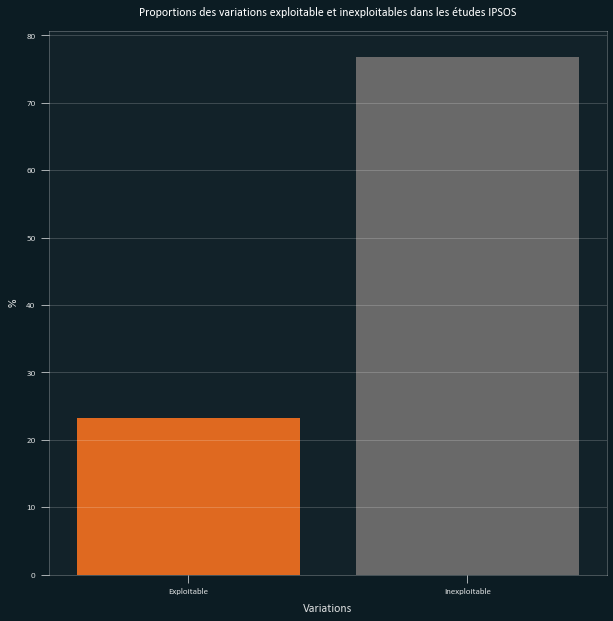

In [113]:
fig = plt.figure(figsize=(10,10))
ax=sns.barplot(x='Inexploitable', y='Inexploitable', data=df_inex, estimator=lambda x: len(x) / len(df_inex) * 100)
ax.set(ylabel="%")
ax.set(xlabel="Variations")
ax.set(title='Proportions des variations exploitable et inexploitables dans les études IPSOS')
ax.set(xticklabels=['Exploitable', 'Inexploitable'])
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

fig.savefig('plot.png',dpi=200)

In [114]:
print(df_inex.Inexploitable.value_counts())
df_inex.Inexploitable.value_counts()/len(df_inex)

True     78028
False    23540
Name: Inexploitable, dtype: int64


True     0.768234
False    0.231766
Name: Inexploitable, dtype: float64

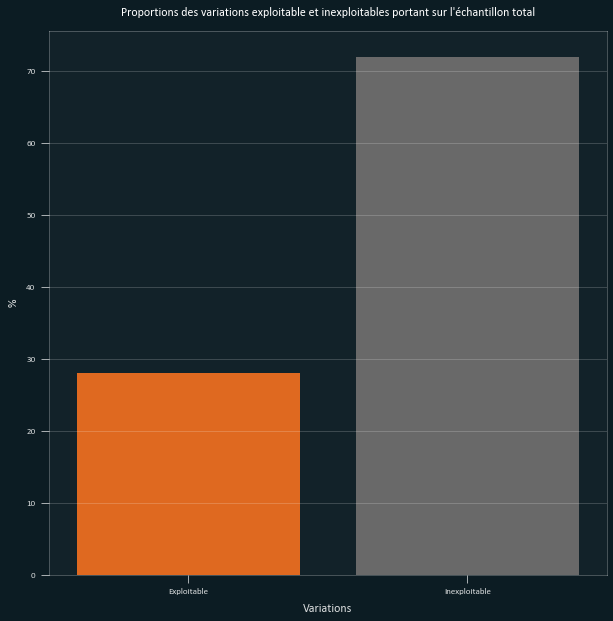

In [115]:
df_inex_ens=df_inex[df_inex.Categorie=='ENSEMBLE']
fig = plt.figure(figsize=(10,10))
ax=sns.barplot(x='Inexploitable', y='Inexploitable', data=df_inex_ens, estimator=lambda x: len(x) / len(df_inex_ens) * 100)
ax.set(ylabel="%")
ax.set(xlabel="Variations")
ax.set(title="Proportions des variations exploitable et inexploitables portant sur l'échantillon total")
ax.set(xticklabels=['Exploitable', 'Inexploitable'])
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
fig.savefig('plot.png',dpi=200)


In [116]:
print(df_inex_ens.Inexploitable.value_counts())
df_inex_ens.Inexploitable.value_counts()/len(df_inex_ens)

True     1045
False     407
Name: Inexploitable, dtype: int64


True     0.719697
False    0.280303
Name: Inexploitable, dtype: float64

## Inexploitable sur groupe ENSEMBLE (seulement tous les sondés)

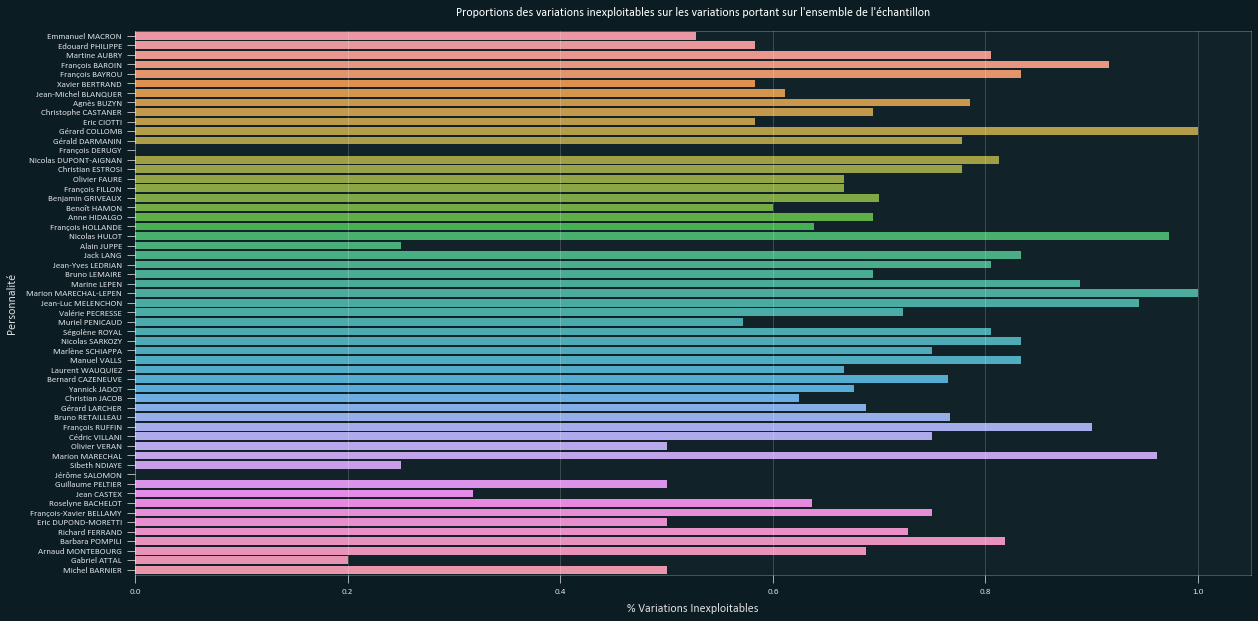

In [117]:
fig = plt.figure(figsize=(20,10))
ax=sns.barplot(x='Inexploitable',y='Nom',data=df_inex_ens,ci=None
#  ,estimator=lambda x: len(x) / len(df_inex[df_inex.Categorie=='ENSEMBLE']) * 100
)
ax.set(title="Proportions des variations inexploitables sur les variations portant sur l'ensemble de l'échantillon")
ax.set(xlabel="% Variations Inexploitables")
ax.set(ylabel="Personnalité ")
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

fig.savefig('plot.png',dpi=200)

In [118]:
print(df_inex_ens['Inexploitable'].value_counts()/len(groupe))
print(df_inex_ens['Inexploitable'].value_counts())
# data_f['Inexploitable Défavorable'].value_counts()

True     0.719697
False    0.280303
Name: Inexploitable, dtype: float64
True     1045
False     407
Name: Inexploitable, dtype: int64


## Inexploitable sur toutes les variations

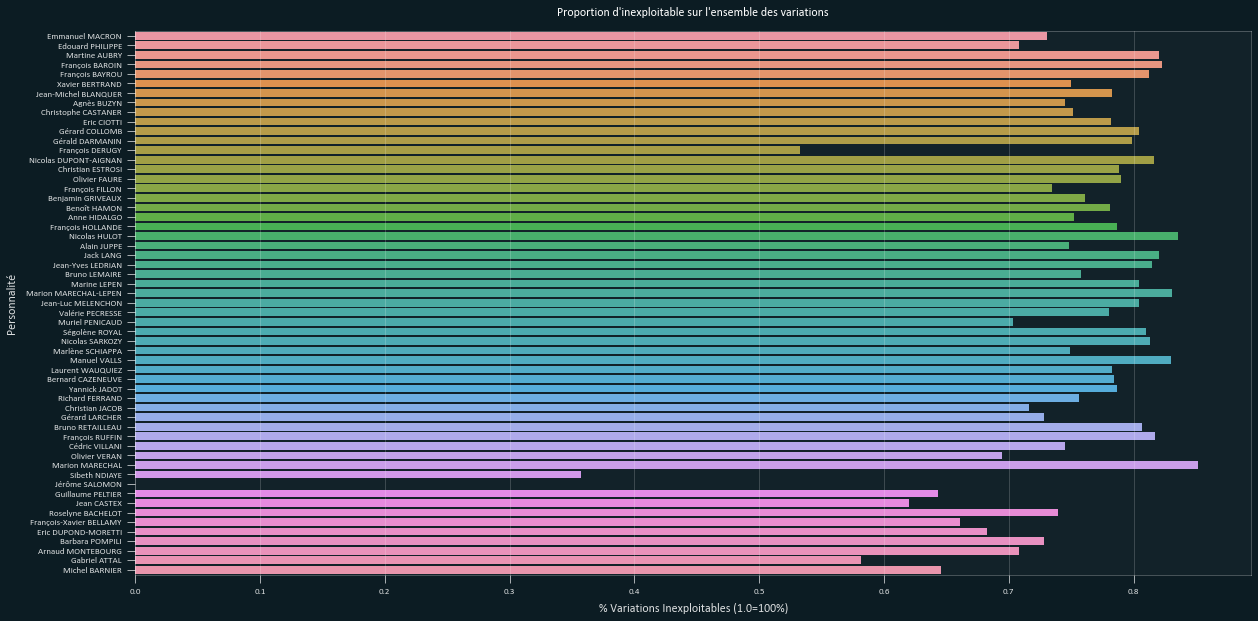

In [119]:
fig = plt.figure(figsize=(20,10))
ax=sns.barplot(x='Inexploitable',y='Nom',data=df_inex,ci=None\
#  ,estimator=lambda x: len(x) / len(df_inex[df_inex.Categorie=='ENSEMBLE']) * 100
)
ax.set(xlabel="% Variations Inexploitables (1.0=100%)")
ax.set(title="Proportion d'inexploitable sur l'ensemble des variations")
ax.set(ylabel="Personnalité ")
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

fig.savefig('plot.png',dpi=200)

In [120]:
print(df_inex['Inexploitable'].value_counts()/len(df_inex))
print(df_inex['Inexploitable'].value_counts())

True     0.768234
False    0.231766
Name: Inexploitable, dtype: float64
True     78028
False    23540
Name: Inexploitable, dtype: int64


## Taille échantillons groupes de gauche

In [121]:
data_f[data_f.Categorie=='Proximitépolitique'].Groupe.value_counts()

STFIPdGPC                  726
PS                         726
EELV                       726
LREM                       726
MoDem                      726
UDI                        726
LR                         726
DLF                        726
RN                         726
Aucunparti                 726
STGauche(FIPdGPCPSEELV)    726
STCentre(ModemLREM)        726
STDroite(LRUDI)            726
Name: Groupe, dtype: int64

In [122]:
filtre_soutien_gauche= (data_f.Groupe == 'PS') | (data_f.Groupe == 'EELV') | (data_f.Groupe == 'STFIPdGPC') # | (data_f.Groupe == 'STGauche(FIPdGPCPSEELV)') 
filtre_soutien_gauche_full= (data_f.Groupe == 'PS') | (data_f.Groupe == 'EELV') | (data_f.Groupe == 'STFIPdGPC')  | (data_f.Groupe == 'STGauche(FIPdGPCPSEELV)') 
taille_gauche_full=data_f[filtre_soutien_gauche_full][['Base','Date','Groupe']]
# test_df=taille_gauche_full=data_f[filtre_soutien_gauche_full][['Base','Date','Groupe']].pivot_table(values='Base',index=['Date'],columns=['Groupe'])
taille_gauche_detail=data_f[filtre_soutien_gauche][['Base','Date','Groupe']].pivot_table(values='Base',index=['Date'],columns=['Groupe'])
taille_gauche_detail.rename(columns={'STFIPdGPC':'FI-PdG-PC'}, inplace=True)
taille_gauche_detail=taille_gauche_detail[['FI-PdG-PC','PS','EELV']]
taille_gauche_full.replace('STFIPdGPC','FI-PdG-PC',inplace=True)
taille_gauche_full.replace('STGauche(FIPdGPCPSEELV)','Soutien Gauche (Total)',inplace=True)

In [123]:
macron_ens.head()

,index,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable
0,0,Emmanuel MACRON,ENSEMBLE,ENSEMBLE,971.0,3.2,16.4,19.6,26.2,49.8,76.0,4.4,-6.4,5.7,2018-12-08,False,False,2.496908,2.686327
1,0,Emmanuel MACRON,ENSEMBLE,ENSEMBLE,1009.0,6.0,30.1,36.1,27.8,31.1,58.9,5.0,5.3,-5.1,2019-09-14,False,False,2.963565,3.035911
2,0,Emmanuel MACRON,ENSEMBLE,ENSEMBLE,1008.0,6.5,25.9,32.4,31.2,31.1,62.3,5.3,-3.7,3.4,2019-10-12,False,True,2.889160,2.991855
3,0,Emmanuel MACRON,ENSEMBLE,ENSEMBLE,1001.0,6.0,22.6,28.6,27.9,39.2,67.1,4.4,-4.4,3.8,2019-12-14,False,False,2.799440,2.910705
4,0,Emmanuel MACRON,ENSEMBLE,ENSEMBLE,1000.0,6.8,37.4,44.2,27.4,23.3,50.7,5.1,14.2,-12.3,2020-03-20,False,False,3.078111,3.098728


### Plot stack

(0.0, 350.0)

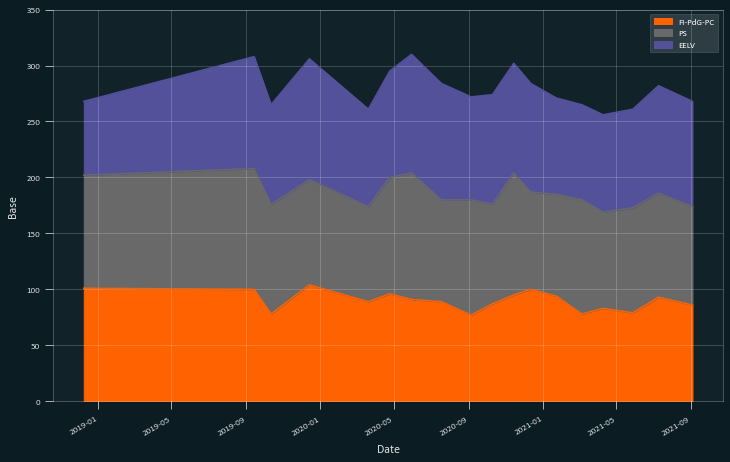

In [124]:

# fig = plt.figure(figsize=(12,8))
# ax=sns.lineplot(data=taille_gauche_detail,x='Date',y='Base',hue='Groupe')
# ax=sns.lineplot(data=taille_echantillon_gauche,x='Date',y='Base')

ax=taille_gauche_detail.plot.area(figsize=(12,8))
macron_ens=data_f[(data_f.Nom=='Emmanuel MACRON') & (data_f.Categorie=='ENSEMBLE')].reset_index()
sns.lineplot(data=macron_ens,x='Date',y='Base')
taille_gauche_detail
ax.set_ylim(0,350)

### Plot line

In [125]:
taille_gauche_full["Erreur"]=error_p(taille_gauche_full.Base/1000,1000)*1000
taille_gauche_full=taille_gauche_full.reset_index()

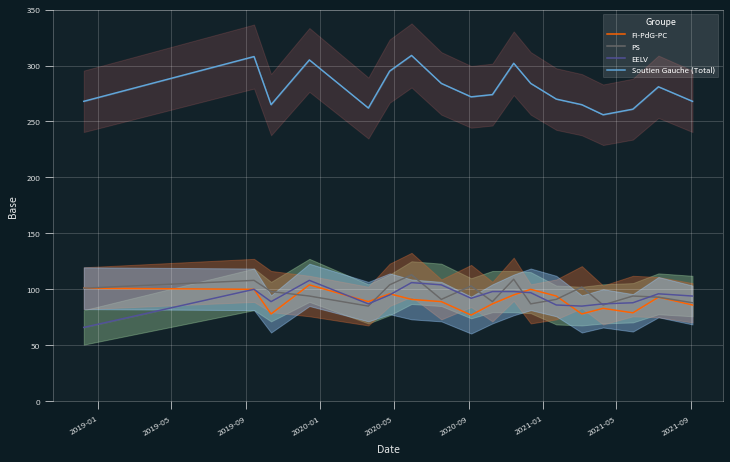

In [126]:
# years = mdates.YearLocator()   # every year
# months = mdates.MonthLocator()  # every month
# years_fmt = mdates.DateFormatter('%m-%Y')

fig = plt.figure(figsize=(12,8))
# ax=sns.lineplot(data=taille_gauche_detail,x='Date',y='Base',hue='Groupe')
ax=sns.lineplot(data=taille_gauche_full,x='Date',y='Base',hue='Groupe',err_style='band')
ax.set_ylim(0,350)

# # format the ticks
# ax.xaxis.set_major_locator(months)
# ax.xaxis.set_major_formatter(years_fmt)
# # ax.xaxis.set_minor_locator(months)

# # round to nearest years.
# datemin = np.datetime64(taille_gauche_full.Date.min())
# datemax = np.datetime64(taille_gauche_full.Date.max())
# ax.set_xlim(datemin, datemax)
# ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

# Organise date on ticks automatically
fig.autofmt_xdate()

total_gauche=taille_gauche_full[taille_gauche_full.Groupe=="Soutien Gauche (Total)"]
EELV=taille_gauche_full[taille_gauche_full.Groupe=="EELV"]
PS=taille_gauche_full[taille_gauche_full.Groupe=="PS"]
FI=taille_gauche_full[taille_gauche_full.Groupe=="FI-PdG-PC"]

plt.fill_between(total_gauche.Date, total_gauche.Base-total_gauche.Erreur, total_gauche.Base+total_gauche.Erreur,color='#cc6666', alpha=.2)
plt.fill_between(EELV.Date, EELV.Base-EELV.Erreur, EELV.Base+EELV.Erreur,color='#99cc99', alpha=.4)
plt.fill_between(PS.Date, PS.Base-PS.Erreur, PS.Base+PS.Erreur,color='#cc6633', alpha=.4)
plt.fill_between(FI.Date, FI.Base-FI.Erreur, FI.Base+FI.Erreur,color='#99ccff', alpha=.4)


# Variations personnalité

In [127]:
print(data_f.Categorie.value_counts())
data_f[data_f.Categorie=='Proximitépolitique'].Groupe.value_counts()

Proximitépolitique                   9438
Age                                  6534
PCSdel'individu                      5807
PCSdelapersonnederéférencedufoyer    5521
VotePrésidentielle20171ertour        5082
Région                               4356
Catégoried'agglomération             3630
Revenumensuelnetdufoyer              2904
VotePrésidentielle20172ndtour        2904
Diplômeleplusélevé                   2070
Sexe                                 1452
ENSEMBLE                              726
Agriculteurexploitant                 252
Niveaud'études                        108
Name: Categorie, dtype: int64


STFIPdGPC                  726
PS                         726
EELV                       726
LREM                       726
MoDem                      726
UDI                        726
LR                         726
DLF                        726
RN                         726
Aucunparti                 726
STGauche(FIPdGPCPSEELV)    726
STCentre(ModemLREM)        726
STDroite(LRUDI)            726
Name: Groupe, dtype: int64

In [128]:
nom='Jean CASTEX'
data_pers=data_f[(data_f.Nom==nom) & (data_f.Groupe=='ENSEMBLE')].reset_index()
data_pers['Erreur favorable']=error_p(data_pers['ST Favorable']/100,data_pers.Base)*100
data_pers['Erreur défavorable']=error_p(data_pers['ST Défavorable']/100,data_pers.Base)*100
data_pers

,index,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,...,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable,Erreur favorable,Erreur défavorable
0,70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1000.0,4.8,27.9,32.7,15.8,11.5,...,39.9,0.0,0.0,2020-07-18,False,False,2.907619,2.761243,2.907619,2.761243
1,70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1000.0,4.0,32.9,37.0,23.0,18.0,...,22.0,4.2,13.7,2020-09-05,False,False,2.992452,3.048414,2.992452,3.048414
2,70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1000.0,3.4,31.6,35.0,30.4,18.2,...,16.4,-2.0,7.6,2020-10-10,True,False,2.956288,3.097817,2.956288,3.097817
3,70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1000.0,2.9,28.5,31.4,33.4,26.7,...,8.5,-3.6,11.4,2020-11-14,False,False,2.876623,3.035147,2.876623,3.035147
4,70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1000.0,3.1,32.9,36.0,29.7,27.3,...,6.9,4.6,-3.0,2020-12-12,False,True,2.975071,3.068511,2.975071,3.068511
5,70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1000.0,3.4,28.3,31.7,34.3,27.0,...,7.0,-4.3,4.3,2021-01-23,False,False,2.884005,3.018852,2.884005,3.018852
6,70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1000.0,4.6,31.6,36.3,32.4,23.5,...,7.8,4.6,-5.4,2021-03-06,False,False,2.980431,3.077381,2.980431,3.077381
7,70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1002.0,2.9,28.5,31.4,32.4,29.8,...,6.4,-4.9,6.3,2021-04-10,False,False,2.873751,3.002364,2.873751,3.002364
8,70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1000.0,4.0,31.5,35.6,30.7,27.9,...,5.8,4.2,-3.5,2021-05-29,False,True,2.967727,3.051758,2.967727,3.051758
9,70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1000.0,5.1,30.0,35.1,35.0,21.6,...,8.3,-0.4,-2.0,2021-07-10,True,True,2.958230,3.071915,2.958230,3.071915


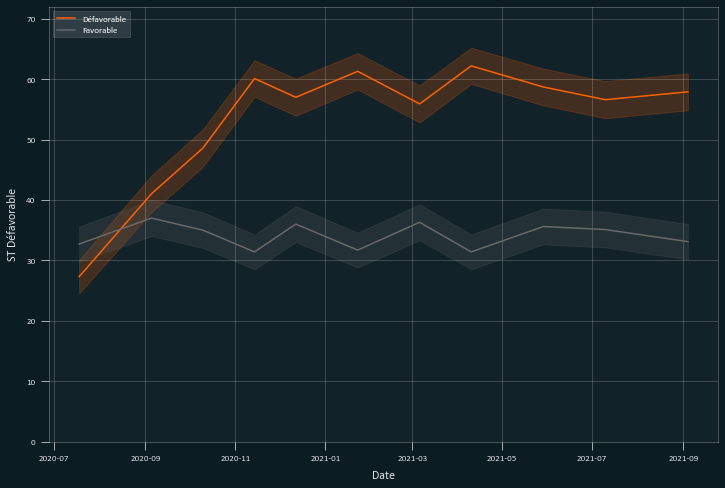

In [129]:


fig = plt.figure(figsize=(12,8))
# ax=sns.lineplot(data=taille_gauche_detail,x='Date',y='Base',hue='Groupe')

ax=sns.lineplot(data=data_pers,x='Date',y='ST Défavorable',label='Défavorable')
current_color=ax.get_lines()[0].get_color()
plt.fill_between(data_pers.Date, data_pers['ST Défavorable']-data_pers['Erreur défavorable'], data_pers['ST Défavorable']+data_pers['Erreur défavorable'],color=current_color, alpha=.2)

sns.lineplot(data=data_pers,x='Date',y='ST Favorable',label='Favorable')
current_color=ax.get_lines()[1].get_color()
plt.fill_between(data_pers.Date, data_pers['ST Favorable']-data_pers['Erreur favorable'], data_pers['ST Favorable']+data_pers['Erreur favorable'],color=current_color, alpha=.2)

# Organise date on ticks automatically
# fig.autofmt_xdate()
ax.set_ylim(0,int(np.max([data_pers['ST Favorable'].max(),data_pers['ST Défavorable'].max()]))+10)
plt.legend(loc='upper left')

# Analyse du dernier rapport

In [130]:
all_dates=np.sort(data_f.Date.unique())
most_recent=all_dates[-1]
scd_most_recent=all_dates[-2]

In [131]:
last_data=data_f[data_f.Date==data_f.Date.max()]
last_inex=pd.DataFrame()
last_inex['Résultats']=pd.concat([last_data['ST Favorable'],last_data['ST Défavorable']])
last_inex['Categorie']=pd.concat([last_data['Categorie'],last_data['Categorie']])
last_inex['Groupe']=pd.concat([last_data['Groupe'],last_data['Groupe']])
last_inex['Inexploitable']=pd.concat([last_data['Inexploitable Favorable'],last_data['Inexploitable Défavorable']])
last_inex['Nom']=pd.concat([last_data['Nom'],last_data['Nom']])
last_inex

,Résultats,Categorie,Groupe,Inexploitable,Nom
0,40.4,ENSEMBLE,ENSEMBLE,True,Emmanuel MACRON
1,42.2,Sexe,Homme,True,Emmanuel MACRON
2,38.8,Sexe,Femme,True,Emmanuel MACRON
3,50.0,Age,18à24ans,True,Emmanuel MACRON
4,36.0,Age,25à34ans,True,Emmanuel MACRON
...,...,...,...,...,...
2935,46.3,VotePrésidentielle20171ertour,STNonexpr.,True,Laurent WAUQUIEZ
2936,33.1,VotePrésidentielle20172ndtour,EmmanuelMacron,True,Laurent WAUQUIEZ
2937,70.3,VotePrésidentielle20172ndtour,MarineLePen,True,Laurent WAUQUIEZ
2938,45.7,VotePrésidentielle20172ndtour,STExpr.,True,Laurent WAUQUIEZ


## Inexploitables global

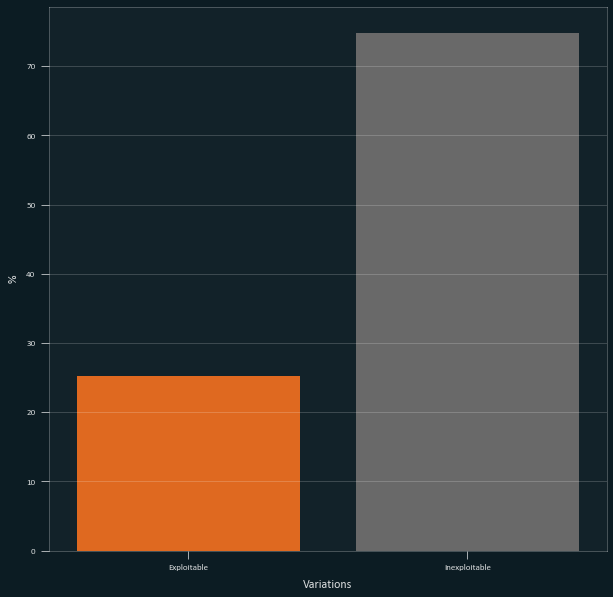

In [132]:
fig = plt.figure(figsize=(10,10))
ax=sns.barplot(x='Inexploitable', y='Inexploitable', data=last_inex, estimator=lambda x: len(x) / len(last_inex) * 100)
ax.set(ylabel="%")
ax.set(xlabel="Variations")
ax.set(xticklabels=['Exploitable', 'Inexploitable'])
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

fig.savefig('plot.png')

In [133]:
print(last_inex.Inexploitable.value_counts())
last_inex.Inexploitable.value_counts()/len(last_inex)

True     4399
False    1481
Name: Inexploitable, dtype: int64


True     0.748129
False    0.251871
Name: Inexploitable, dtype: float64

## Inexploitable par personnalité

### Inexploitable sur tout le jeu de données

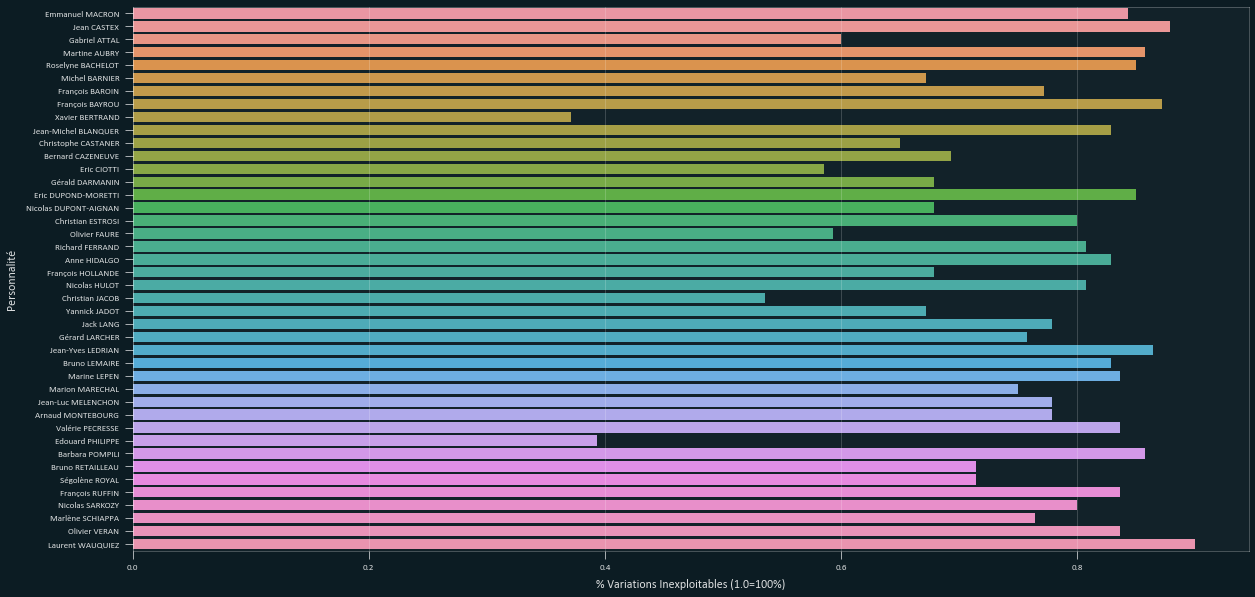

In [134]:
fig = plt.figure(figsize=(20,10))
ax=sns.barplot(x='Inexploitable',y='Nom',data=last_inex,ci=None
#  ,estimator=lambda x: len(x) / len(df_inex[df_inex.Categorie=='ENSEMBLE']) * 100
)
ax.set(xlabel="% Variations Inexploitables (1.0=100%)")
ax.set(ylabel="Personnalité ")
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

fig.savefig('plot.png')

In [135]:
print(last_inex['Inexploitable'].value_counts()/len(last_inex))
print(last_inex['Inexploitable'].value_counts())

True     0.748129
False    0.251871
Name: Inexploitable, dtype: float64
True     4399
False    1481
Name: Inexploitable, dtype: int64


### Inexploitable sur le groupe ENSEMBLE

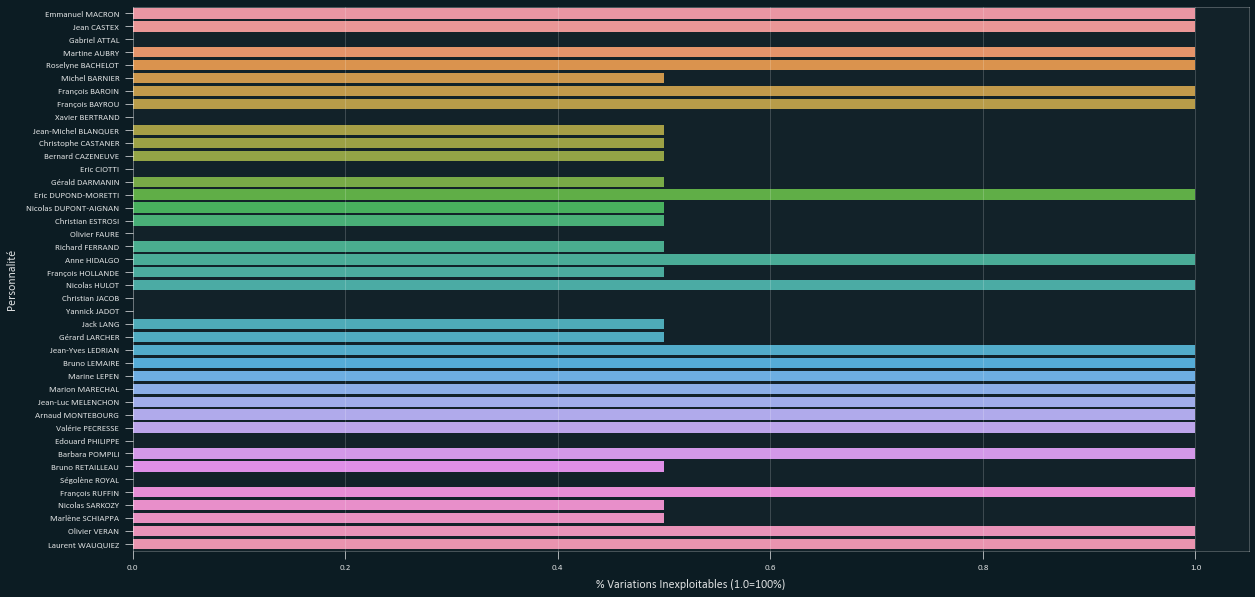

In [136]:
last_inex_ens=last_inex[last_inex.Categorie=='ENSEMBLE']
fig = plt.figure(figsize=(20,10))
ax=sns.barplot(x='Inexploitable',y='Nom',data=last_inex_ens,ci=None
#  ,estimator=lambda x: len(x) / len(df_inex[df_inex.Categorie=='ENSEMBLE']) * 100
)
ax.set(xlabel="% Variations Inexploitables (1.0=100%)")
ax.set(ylabel="Personnalité ")
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

fig.savefig('plot.png')

In [137]:
print(last_inex_ens['Inexploitable'].value_counts()/len(last_inex_ens))
print(last_inex_ens['Inexploitable'].value_counts())

True     0.642857
False    0.357143
Name: Inexploitable, dtype: float64
True     54
False    30
Name: Inexploitable, dtype: int64


In [138]:
nom='SCHIA'
categorie='Proximitépolitique'
last_inex[(last_inex.Nom.str.contains(nom))&(last_inex.Inexploitable==False)]

,Résultats,Categorie,Groupe,Inexploitable,Nom
2730,30.5,ENSEMBLE,ENSEMBLE,False,Marlène SCHIAPPA
2731,31.8,Sexe,Homme,False,Marlène SCHIAPPA
2733,27.2,Age,18à24ans,False,Marlène SCHIAPPA
2738,33.8,Age,70ansetplus,False,Marlène SCHIAPPA
2739,27.7,Age,STMoinsde35ans,False,Marlène SCHIAPPA
2742,8.1,PCSdelapersonnederéférencedufoyer,Agriculteurexploitant,False,Marlène SCHIAPPA
2743,58.0,PCSdelapersonnederéférencedufoyer,Professionindépendante,False,Marlène SCHIAPPA
2747,24.0,PCSdelapersonnederéférencedufoyer,Ouvrier,False,Marlène SCHIAPPA
2750,11.1,PCSdel'individu,Agriculteurexploitant,False,Marlène SCHIAPPA
2755,23.8,PCSdel'individu,Ouvrier,False,Marlène SCHIAPPA


In [139]:
last_inex.Categorie.unique()

array(['ENSEMBLE', 'Sexe', 'Age', 'PCSdelapersonnederéférencedufoyer',
       "PCSdel'individu", 'Région', "Catégoried'agglomération",
       'Revenumensuelnetdufoyer', 'Diplômeleplusélevé',
       'Proximitépolitique', 'VotePrésidentielle20171ertour',
       'VotePrésidentielle20172ndtour'], dtype=object)

## Variation d'une personnalité sur les deux derniers jeux de données

In [140]:
nom="Emmanuel MACRON"
short_d=data_f[(data_f.Nom==nom) & ((data_f.Date==most_recent) | (data_f.Date==scd_most_recent)) & (data_f.Groupe=='Rural')].sort_values(by='Date',ascending=True,ignore_index=True)
print('Favorable')
print((margin_p(short_d['ST Favorable']/100,short_d.Base)*100).T)
print('Défavorable')
print((margin_p(short_d['ST Défavorable']/100,short_d.Base)*100).T)
short_d

Favorable
[[30.2644951  42.7355049 ]
 [30.84322399 43.35677601]]
Défavorable
[[50.79147284 63.60852716]
 [48.25265226 61.14734774]]


,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable
0,Emmanuel MACRON,Catégoried'agglomération,Rural,229.0,7.4,29.1,36.5,25.2,32.0,57.2,6.3,3.0,-6.6,2021-07-10,True,True,6.235505,6.408527
1,Emmanuel MACRON,Catégoried'agglomération,Rural,229.0,5.6,31.4,37.1,21.6,33.0,54.7,8.3,0.6,-2.5,2021-09-04,True,True,6.256776,6.447348


In [141]:
data_f[(data_f.Nom==nom) & (data_f.Date==most_recent) & (data_f['Inexploitable Favorable']==False)]

,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable
7,Emmanuel MACRON,Age,60à69ans,142.0,9.4,39.8,49.2,22.8,27.6,50.4,0.4,17.3,-10.0,2021-09-04,False,False,8.222925,8.223714
10,Emmanuel MACRON,Age,ST35à59ans,436.0,6.3,27.6,33.9,24.5,33.6,58.1,8.0,0.0,-1.8,2021-09-04,False,True,4.443379,4.631353
11,Emmanuel MACRON,Age,ST60ansetplus,299.0,7.6,41.3,48.9,24.8,25.6,50.5,0.7,10.0,-5.5,2021-09-04,False,True,5.666115,5.667203
18,Emmanuel MACRON,PCSdelapersonnederéférencedufoyer,Retraité,292.0,6.5,41.3,47.8,25.0,24.6,49.7,2.6,8.1,-6.2,2021-09-04,False,True,5.729462,5.734913
26,Emmanuel MACRON,PCSdel'individu,Retraité,275.0,6.3,40.2,46.5,26.4,25.5,51.9,1.6,8.7,-6.1,2021-09-04,False,True,5.895126,5.905354
35,Emmanuel MACRON,Catégoried'agglomération,Moinsde20.000hab,173.0,7.7,32.0,39.7,30.0,26.0,55.9,4.4,8.8,-4.3,2021-09-04,False,True,7.290997,7.398748
36,Emmanuel MACRON,Catégoried'agglomération,20.000à100.000hab.,134.0,5.6,33.9,39.5,25.8,28.9,54.7,5.8,-10.6,12.3,2021-09-04,False,False,8.277132,8.428425
41,Emmanuel MACRON,Revenumensuelnetdufoyer,De2.000-3.000€,245.0,4.0,27.1,31.1,31.0,33.5,64.5,4.4,-10.3,8.2,2021-09-04,False,False,5.796460,5.991935
46,Emmanuel MACRON,Proximitépolitique,STFIPdGPC,86.0,11.0,11.4,22.3,28.6,47.3,75.9,1.8,-10.6,11.8,2021-09-04,False,False,8.797713,9.039330
49,Emmanuel MACRON,Proximitépolitique,LREM,126.0,33.7,63.5,97.2,2.0,0.8,2.8,0.0,3.9,-2.4,2021-09-04,False,True,2.880600,2.880600


# Dernière variation observable

In [142]:


def find_last_var(df):
    last_var={}
    for nom in df.Nom.unique():
        last_var[nom]={'fav':None,'defav':None,'date_fav':None,'date_defav':None}
        df_var=df[(df.Nom==nom) & (df.Categorie=='ENSEMBLE')]
        df_var=df_var.sort_values(by='Date',ascending=False,ignore_index=True)
        l_base=df_var.iloc[0].Base
        l_fav=df_var.iloc[0]['ST Favorable']
        l_defav=df_var.iloc[0]['ST Défavorable']
        er_l_fav=error_p(l_fav/100,l_base)*100
        er_l_defav=error_p(l_defav/100,l_base)*100
        for i in range(1,len(df_var)):
            t=df_var.iloc[i]
            t_base=t.Base
            t_fav=t['ST Favorable']
            t_defav=t['ST Défavorable']
            er_t_fav=error_p(t_fav/100,t_base)*100
            er_t_defav=error_p(t_defav/100,t_base)*100
            # print(l_fav,er_l_fav,t_fav,er_t_fav)
            if l_fav+er_l_fav < t_fav-er_t_fav and last_var[nom]['fav']==None:
                last_var[nom]['fav']= t_fav-er_t_fav-(l_fav+er_l_fav)
                last_var[nom]['date_fav']= t.Date                
            elif l_fav-er_l_fav > t_fav+er_t_fav and last_var[nom]['fav']==None:
                last_var[nom]['fav']= l_fav+er_l_fav-(t_fav-er_t_fav)
                last_var[nom]['date_fav']= t.Date                
            if l_defav+er_l_defav < t_defav-er_t_defav and last_var[nom]['defav']==None:
                last_var[nom]['defav']= t_defav-er_t_defav-(l_defav+er_l_defav)
                last_var[nom]['date_defav']= t.Date                
            elif l_defav-er_l_defav > t_defav+er_t_defav and last_var[nom]['defav']==None:
                last_var[nom]['defav']= l_defav+er_l_defav-(t_defav-er_t_defav)
                last_var[nom]['date_defav']= t.Date                
    return last_var

In [143]:
nom='Emmanuel MACRON'
last_var=find_last_var(data_f)
last_var[nom] 

{'fav': 17.64081432804611,
 'defav': 0.46677473230496247,
 'date_fav': Timestamp('2019-12-14 00:00:00'),
 'date_defav': Timestamp('2021-01-23 00:00:00')}

In [144]:
def find_last_var_usable(df):
    cols=['Nom','VarFav','DateFav','VarDefav','DateDefav']
    last_var=pd.DataFrame(columns=cols)
    for nom in df.Nom.unique():   
        t_uple=[nom]
        c_df=df.loc[(df.Nom==nom) & (df['Inexploitable Favorable']==False) & (df['Evolution ST Favorable']!=0)].sort_values(by=['Date'],ascending=False)
        if not c_df.empty:
            dernier_val=c_df.iloc[0]
            t_uple.append(dernier_val['Evolution ST Favorable'])
            t_uple.append(dernier_val['Date'])
        else:
            t_uple.extend([np.nan,np.nan])
            
        c_df=df.loc[(df.Nom==nom) & (df['Inexploitable Défavorable']==False) & (df['Evolution ST Défavorable']!=0)].sort_values(by=['Date'],ascending=False)
        if not c_df.empty:
            dernier_val=c_df.iloc[0]
            t_uple.append(dernier_val['Evolution ST Défavorable'])
            t_uple.append(dernier_val['Date'])
        else:
            t_uple.extend([np.nan,np.nan])
        last_var=last_var.append(pd.Series(t_uple, index=cols),ignore_index=True)
    return last_var


In [145]:
find_last_var_usable(data_f[data_f.Categorie=='ENSEMBLE'])

,Nom,VarFav,DateFav,VarDefav,DateDefav
0,Emmanuel MACRON,-3.8,2021-04-10,5.0,2021-04-10 00:00:00
1,Edouard PHILIPPE,-9.1,2021-09-04,7.9,2021-09-04 00:00:00
2,Martine AUBRY,-3.5,2020-05-30,-5.8,2021-07-10 00:00:00
3,François BAROIN,-4.5,2021-05-29,-4.3,2020-11-14 00:00:00
4,François BAYROU,-3.8,2019-12-14,-3.7,2020-12-12 00:00:00
5,Xavier BERTRAND,-10.7,2021-09-04,7.1,2021-09-04 00:00:00
6,Jean-Michel BLANQUER,-3.3,2021-09-04,-4.4,2021-07-10 00:00:00
7,Agnès BUZYN,-4.8,2020-04-24,8.0,2020-03-20 00:00:00
8,Christophe CASTANER,-5.9,2021-09-04,4.6,2021-04-10 00:00:00
9,Eric CIOTTI,-4.6,2021-09-04,5.1,2021-09-04 00:00:00


## Verification pas de données bizarre

In [146]:
data_f[data_f.Base==0]



,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable


In [147]:
favUnmatch=data_f[np.abs(data_f['Très favorable']+data_f['Plutôt favorable']-data_f['ST Favorable'])>0.11]
favUnmatch

,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable


In [148]:
defavUnmatch=data_f[np.abs(data_f['Très défavorable']+data_f['Plutôt défavorable']-data_f['ST Défavorable'])>0.11]
defavUnmatch

,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable


In [149]:
unmatch=data_f[np.abs(data_f['ST Favorable']+data_f['ST Défavorable']+data_f['Nsp'])<99.89]
unmatch



,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable


In [150]:
dates=np.sort(data_f.Date.unique())
last_date=dates[len(dates)-1]
prev_date=dates[len(dates)-2]
l_data=data_f[data_f.Date==last_date]
p_data=data_f[data_f.Date==prev_date]
l_noms=np.sort(l_data.Nom.unique())
p_noms=np.sort(p_data.Nom.unique())


for nom in l_noms:
    if nom in p_noms:
        lastd=l_data[l_data.Nom==nom]
        prevd=p_data[p_data.Nom==nom]
        lastd['Prev_calc']=lastd['ST Favorable']-lastd['Evolution ST Favorable']
        # check_cond=(l_data.Nom==p_data.Nom) & (l_data.Categorie==p_data.Categorie) & (l_data.Groupe==p_data.Groupe)
        lastd['Prev']= prevd['ST Favorable']
        weird=lastd[np.abs(lastd['Prev'] - lastd['Prev_calc'])> 0.11]
        if len(weird)>0:
            weird
        else:
            print('{} is clear'.format(nom))


Anne HIDALGO is clear
Bernard CAZENEUVE is clear
Bruno LEMAIRE is clear
Christian ESTROSI is clear
Christian JACOB is clear
Christophe CASTANER is clear
Emmanuel MACRON is clear
Eric CIOTTI is clear
Eric DUPOND-MORETTI is clear
François BAROIN is clear
François BAYROU is clear
François HOLLANDE is clear
Gabriel ATTAL is clear
Gérald DARMANIN is clear
Gérard LARCHER is clear
Jack LANG is clear
Jean CASTEX is clear
Jean-Luc MELENCHON is clear
Jean-Michel BLANQUER is clear
Jean-Yves LEDRIAN is clear
Marine LEPEN is clear
Marion MARECHAL is clear
Martine AUBRY is clear
Michel BARNIER is clear
Nicolas DUPONT-AIGNAN is clear
Nicolas HULOT is clear
Olivier FAURE is clear
Richard FERRAND is clear
Roselyne BACHELOT is clear
Xavier BERTRAND is clear
Yannick JADOT is clear


C:\Users\Romain\AppData\Local\Temp/ipykernel_28012/3509467607.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lastd['Prev_calc']=lastd['ST Favorable']-lastd['Evolution ST Favorable']
C:\Users\Romain\AppData\Local\Temp/ipykernel_28012/3509467607.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lastd['Prev']= prevd['ST Favorable']


In [151]:
for i in weird.index:
    print(p_data.loc[i ])

In [152]:
last_data

,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable
0,Emmanuel MACRON,ENSEMBLE,ENSEMBLE,1000.0,8.4,32.0,40.4,24.5,28.6,53.1,6.5,1.5,-2.0,2021-09-04,True,True,3.041374,3.093070
1,Emmanuel MACRON,Sexe,Homme,476.0,11.5,30.8,42.2,24.6,28.5,53.2,4.6,0.8,-1.8,2021-09-04,True,True,4.436829,4.482614
2,Emmanuel MACRON,Sexe,Femme,524.0,5.5,33.2,38.8,24.3,28.7,53.0,8.2,2.1,-2.2,2021-09-04,True,True,4.172362,4.273437
3,Emmanuel MACRON,Age,18à24ans,106.0,10.0,40.0,50.0,21.6,20.1,41.7,8.3,-3.6,4.3,2021-09-04,True,True,9.518601,9.386538
4,Emmanuel MACRON,Age,25à34ans,159.0,14.4,21.6,36.0,25.6,26.3,51.9,12.1,-7.3,-0.0,2021-09-04,True,False,7.461029,7.766292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935,Laurent WAUQUIEZ,VotePrésidentielle20171ertour,STNonexpr.,250.0,2.7,16.7,19.4,19.7,26.6,46.3,34.3,-4.7,1.4,2021-09-04,True,True,4.901787,6.181071
2936,Laurent WAUQUIEZ,VotePrésidentielle20172ndtour,EmmanuelMacron,416.0,12.4,42.6,55.1,24.4,8.7,33.1,11.9,2.1,-0.9,2021-09-04,True,True,4.779785,4.522061
2937,Laurent WAUQUIEZ,VotePrésidentielle20172ndtour,MarineLePen,214.0,1.8,10.3,12.1,27.4,42.8,70.3,17.7,-8.0,0.9,2021-09-04,False,True,4.369546,6.122166
2938,Laurent WAUQUIEZ,VotePrésidentielle20172ndtour,STExpr.,630.0,8.8,31.7,40.5,25.4,20.3,45.7,13.8,-1.3,-0.3,2021-09-04,True,True,3.833291,3.889948


# Variation des paramètres non critères pour les quotas

In [153]:
data_f.Categorie.unique()

array(['ENSEMBLE', 'Sexe', 'Age', 'Agriculteurexploitant',
       "PCSdel'individu", 'Région', "Catégoried'agglomération",
       'Revenumensuelnetdufoyer', "Niveaud'études", 'Proximitépolitique',
       'VotePrésidentielle20171ertour', 'VotePrésidentielle20172ndtour',
       'PCSdelapersonnederéférencedufoyer', 'Diplômeleplusélevé'],
      dtype=object)

In [154]:
data_f[data_f.Categorie=='Proximitépolitique'].Groupe.value_counts()

STFIPdGPC                  726
PS                         726
EELV                       726
LREM                       726
MoDem                      726
UDI                        726
LR                         726
DLF                        726
RN                         726
Aucunparti                 726
STGauche(FIPdGPCPSEELV)    726
STCentre(ModemLREM)        726
STDroite(LRUDI)            726
Name: Groupe, dtype: int64

<AxesSubplot:xlabel='Date', ylabel='Base'>

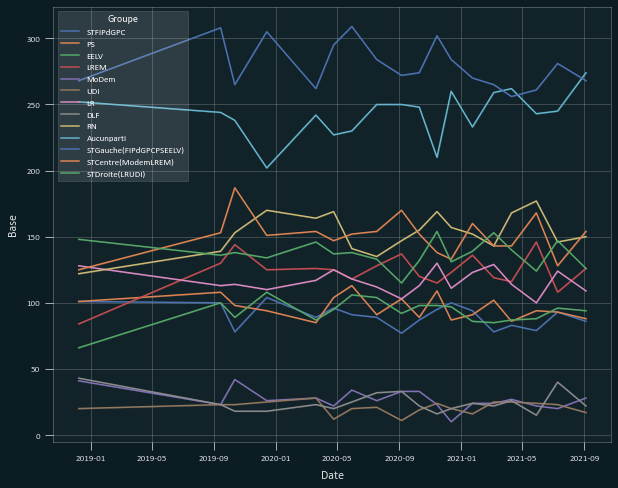

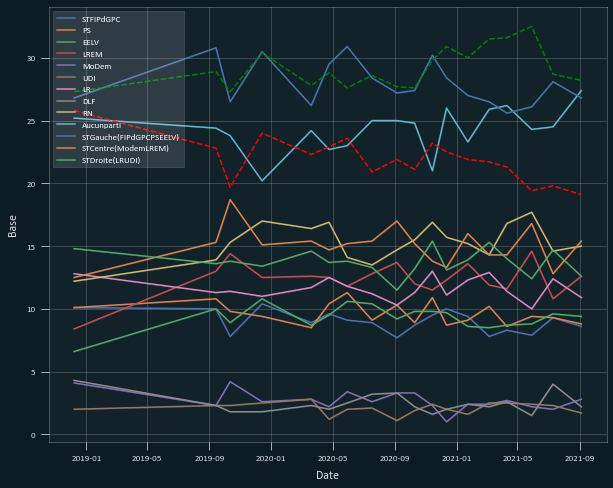

In [155]:
plt.figure(figsize=(10,8))
df_plot=data_f[data_f.Categorie=="Proximitépolitique"].reset_index()
# df_plot=df_plot[df_plot.Groupe.isin(['STFIPdGPC','PS',"EELV",'LREM','MoDem','UDI','LR','DLF','RN','Aucunparti'])]
sns.lineplot(x='Date',y=df_plot.Base,data=df_plot,hue='Groupe', palette="deep")
plt.figure(figsize=(10,8))
sns.lineplot(x='Date',y=df_plot.Base/10,data=df_plot,hue='Groupe', palette="deep")
sns.lineplot(x='Date',y='ST Favorable',data=data_f[(data_f.Categorie=='ENSEMBLE')
        & (data_f.Nom=='Jean-Luc MELENCHON')].reset_index(),color='red',linestyle='--')
sns.lineplot(x='Date',y='ST Favorable',data=data_f[(data_f.Categorie=='ENSEMBLE') & (data_f.Nom=='Marine LEPEN')].reset_index(),color='green',linestyle='--')

In [156]:
data_f[data_f.Categorie=="PCSdel'individu"].Groupe.unique()

array(['Agriculteurexploitant', 'Professionindépendante',
       'Cadresupérieur', 'Professionintermédiaire', 'Employé', 'Ouvrier',
       'Retraité', 'Inactif'], dtype=object)

In [157]:
data_f.Categorie.unique()

array(['ENSEMBLE', 'Sexe', 'Age', 'Agriculteurexploitant',
       "PCSdel'individu", 'Région', "Catégoried'agglomération",
       'Revenumensuelnetdufoyer', "Niveaud'études", 'Proximitépolitique',
       'VotePrésidentielle20171ertour', 'VotePrésidentielle20172ndtour',
       'PCSdelapersonnederéférencedufoyer', 'Diplômeleplusélevé'],
      dtype=object)